In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lightweight_clustered_energy_forecasts.utils.paths import data_dir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Funciones auxiliares

In [3]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [6]:
def add_lags(df):
    target_map = df['kwh'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    return df

In [7]:
def smape(y_true, y_pred):
  numerator = np.abs(y_true - y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  ratio = numerator / denominator
  return ratio.mean()


## Forcasting

In [8]:
building_11a=pd.read_csv(data_dir("interim","11a_clean.csv"),parse_dates=["timestamp"],index_col="timestamp")

In [9]:
building_11a.index.freq="15T"

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_2732\161432725.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  building_11a.index.freq="15T"


In [10]:
building_11a.head()

,kwh
timestamp,
2023-01-01 00:00:00+00:00,15.66
2023-01-01 00:15:00+00:00,15.39
2023-01-01 00:30:00+00:00,12.59
2023-01-01 00:45:00+00:00,11.26
2023-01-01 01:00:00+00:00,16.10


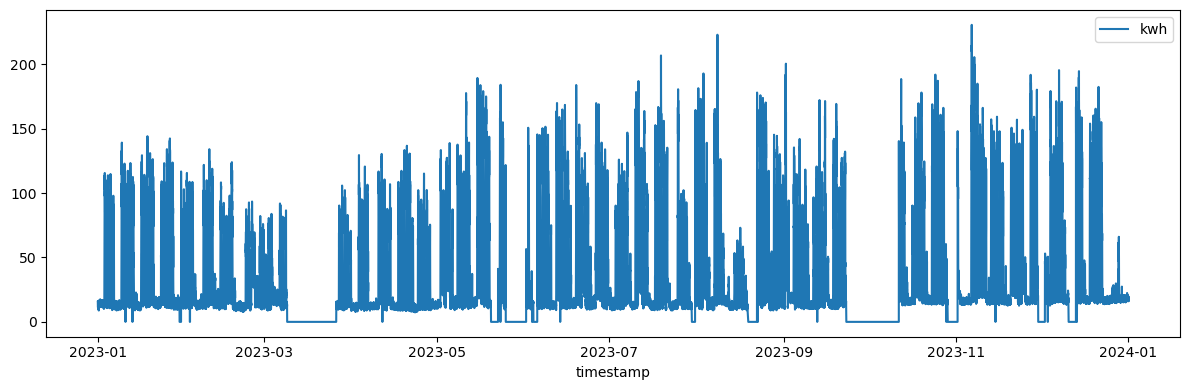

In [11]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [12]:
building_11a_daily=building_11a.resample("D").sum()

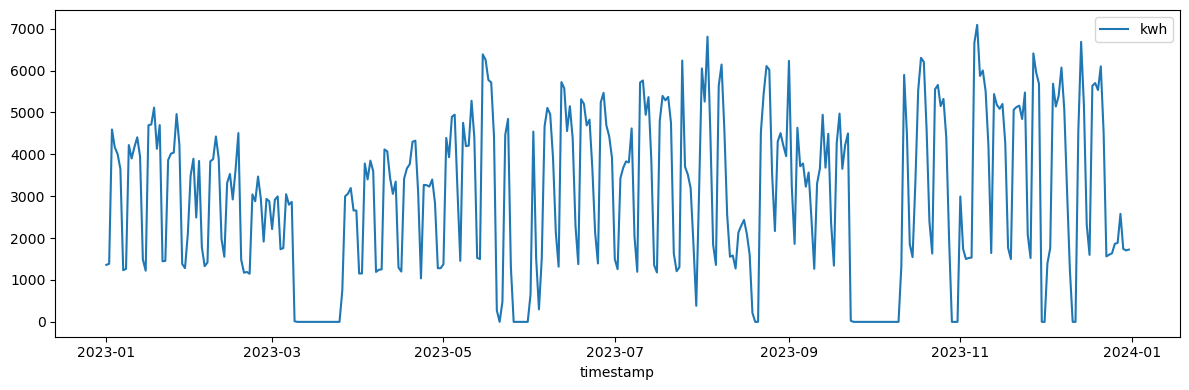

In [13]:
# Configura el tamaño de la figura antes de trazar
plt.figure(figsize=(12, 4))

# Trazar la línea usando sns.lineplot
sns.lineplot(data=building_11a_daily)

# Ajustar el diseño para evitar que los elementos se solapen
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Feature extraction

In [14]:
building_11a_daily =create_features(building_11a_daily)
building_11a_daily=add_lags(building_11a_daily)


In [15]:
train = building_11a_daily.loc[building_11a_daily.index < '2023-12-17']
test = building_11a_daily.loc[building_11a_daily.index >= '2023-12-17']

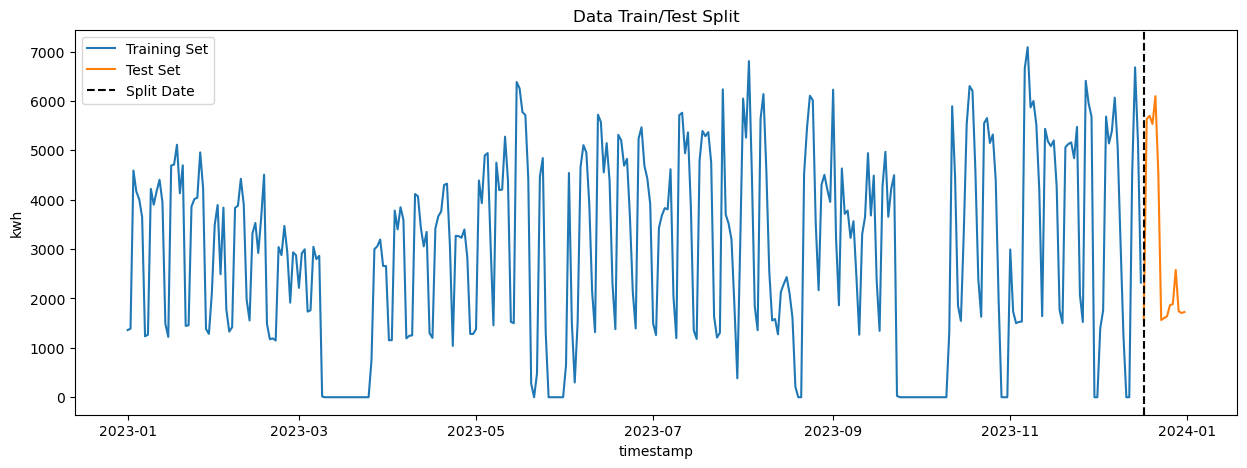

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
# Graficar las líneas para los conjuntos de entrenamiento y prueba
sns.lineplot(data=train, x=train.index, y="kwh", ax=ax, label="Training Set")
sns.lineplot(data=test, x=test.index, y="kwh", ax=ax, label="Test Set")
# Agregar una línea vertical en una fecha específica
ax.axvline(pd.to_datetime('2023-12-17'), color='black', ls='--', label='Split Date')
# Configurar el título y la leyenda
ax.set_title('Data Train/Test Split')
ax.legend()
# Mostrar el gráfico
plt.show()

In [18]:
X_train, y_train =train.drop(columns=["kwh"]), train["kwh"]
X_test, y_test = test.drop(columns=["kwh"]), test["kwh"]

In [19]:
X_test.head()

,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
timestamp,,,,,,,,,
2023-12-17 00:00:00+00:00,6,4,12,351,17,50,6682.45,1240.06,1760.60
2023-12-18 00:00:00+00:00,0,4,12,352,18,51,5161.27,0.00,5684.24
2023-12-19 00:00:00+00:00,1,4,12,353,19,51,2321.18,0.00,5140.37
2023-12-20 00:00:00+00:00,2,4,12,354,20,51,1598.56,4535.88,5390.38
2023-12-21 00:00:00+00:00,3,4,12,355,21,51,5634.90,6682.45,6069.27


## time series cross validation

In [20]:
from sklearn.model_selection import TimeSeriesSplit

In [22]:
#in the test size we define the horizon we want to predict if we want to predict 30 days we have to set 24 hours *30 days
#gap is the space we want to set between the train set ends and the test set starts
tss = TimeSeriesSplit(n_splits=5, test_size=15, gap=1)
df = building_11a_daily.sort_index()

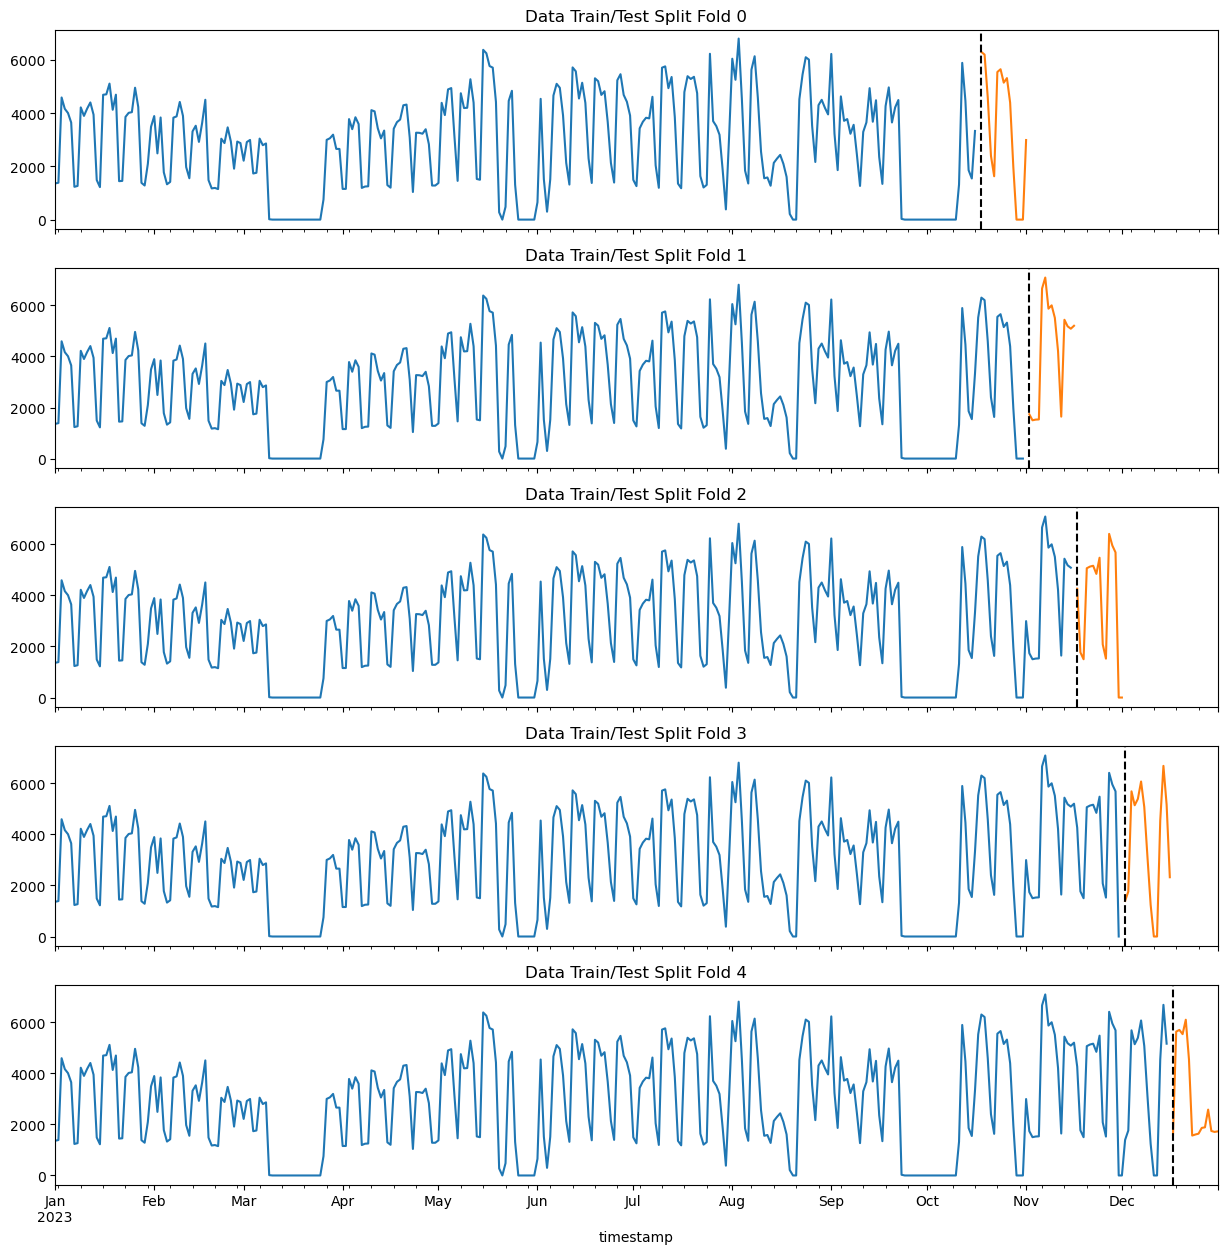

In [23]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['kwh'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['kwh'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Training

In [24]:
tss = TimeSeriesSplit(n_splits=5, test_size=15, gap=1)
df = building_11a_daily.sort_index()

fold = 0
preds = []
scores = []
scores_smape=[]
for train_idx, val_idx in tss.split(df):
    df =create_features(df)
    df=add_lags(df)

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
#    train =create_features(train)
#    train=add_lags(train)
#    test =create_features(test)
#    test=add_lags(test)
    TARGET = 'kwh'

    X_train = train.drop(columns=[TARGET])
    y_train = train[TARGET]

    X_test = test.drop(columns=[TARGET])
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01,eval_metric='mae')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    smape_score=smape(y_test, y_pred)
    scores_smape.append(smape_score)

[0]	validation_0-mae:2762.13558	validation_1-mae:3473.15466
[100]	validation_0-mae:1356.59963	validation_1-mae:2899.99289
[200]	validation_0-mae:889.14951	validation_1-mae:2336.58494
[300]	validation_0-mae:734.11081	validation_1-mae:2107.62783
[400]	validation_0-mae:665.84936	validation_1-mae:2019.85911
[500]	validation_0-mae:619.18108	validation_1-mae:1976.49531
[600]	validation_0-mae:582.17365	validation_1-mae:1951.51112
[692]	validation_0-mae:557.10033	validation_1-mae:1951.66934
[0]	validation_0-mae:2803.86938	validation_1-mae:4263.09026
[100]	validation_0-mae:1375.47231	validation_1-mae:2854.99177
[200]	validation_0-mae:913.31075	validation_1-mae:2348.97634
[300]	validation_0-mae:739.12109	validation_1-mae:2043.95409
[360]	validation_0-mae:690.45253	validation_1-mae:2024.62342
[0]	validation_0-mae:2864.93610	validation_1-mae:3632.17794
[100]	validation_0-mae:1404.89690	validation_1-mae:2036.74955
[200]	validation_0-mae:934.37469	validation_1-mae:1462.69024
[300]	validation_0-mae:7

In [25]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'smape across folds {np.mean(scores_smape):0.4f}')

print(f'Fold scores:{scores}')

Score across folds 2040.8373
smape across folds 0.5689
Fold scores:[np.float64(2175.159043034826), np.float64(2343.329479218028), np.float64(1750.5059691039376), np.float64(2333.420613268918), np.float64(1601.7713133608452)]


In [26]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 500],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Usamos RMSE como métrica
    cv=3
)
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Mostrar el mejor score (RMSE negativo, así que lo multiplicamos por -1)
print("Mejor puntuación de validación (RMSE):", -grid_search.best_score_)

# Mostrar los resultados de todos los parámetros probados
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score', 'std_test_score']])



Mejores parámetros encontrados: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Mejor puntuación de validación (RMSE): 1664.0388603299953
    param_max_depth  param_learning_rate  param_n_estimators  mean_test_score  \
0                 3                 0.01                 200     -1664.038860   
1                 3                 0.01                 300     -1718.766176   
2                 3                 0.01                 500     -1779.957162   
3                 5                 0.01                 200     -1880.373170   
4                 5                 0.01                 300     -1910.167201   
5                 5                 0.01                 500     -1948.685929   
6                 7                 0.01                 200     -1899.732901   
7                 7                 0.01                 300     -1920.401970   
8                 7                 0.01                 500     -1926.904171   
9                 3                 0.0

## Predicting the future

In [27]:
# Entrenar el modelo
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=200,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

In [28]:
from sklearn import set_config
set_config(display="text")

In [29]:
reg.fit(X_train.values, y_train.values, verbose=100)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
predictions = reg.predict(X_test)

In [31]:
smape_score=smape(y_test, predictions)
smape_score

np.float64(0.4614249365426833)

In [32]:
test_df = test.reset_index()
test_df['predictions'] = pd.Series(predictions)

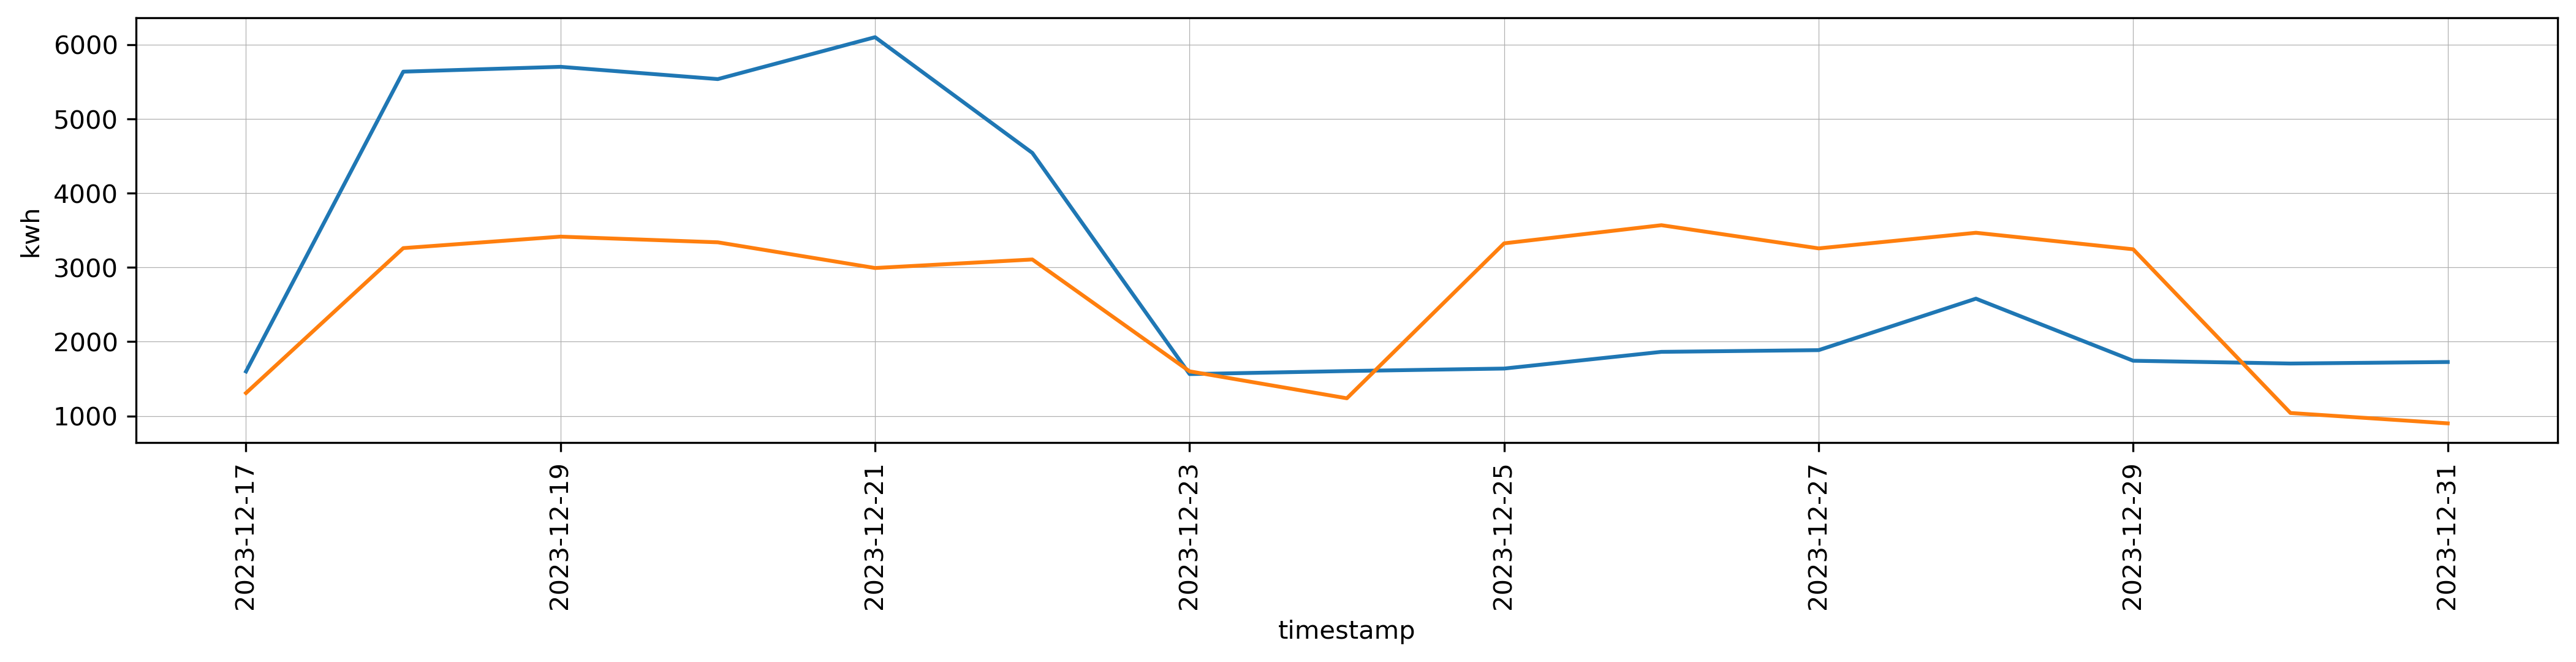

In [33]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=test_df, x='timestamp', y='kwh')
sns.lineplot(data=test_df, x='timestamp', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)